In [1]:
# import dependencies
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Sagi's version of import and fill in missing years:

In [2]:
#names_df = pd.read_csv("Resources/yob1978.txt", delimiter =",", names=["Name", "Gender", "YearOfBirth"],dtype={"Name":"str","Gender":"str", "YearOfBirth":np.int32})

start_year=1880
end_year=2019
yearlist= list(range(start_year,end_year,1))
#print(yearlist)
year_df=pd.DataFrame(yearlist)
year_df["dummy_col"]=1
year_df.set_index("dummy_col", inplace=True)
filename_list=[]
for file in os.listdir("names"):
    if file.endswith(".txt") and int(file[3:7]) >= start_year:
        df =  pd.read_csv("names/"+file, delimiter =",", names=["Name", "Gender", "CountOfNames"],dtype={"Name":"str","Gender":"str", "CountOfNames":np.int32})
        df["Year"] = int(file[3:7])
        
        df = df[["Year", "Name", "Gender", "CountOfNames"]]
        filename_list.append(df)
        
names_df = pd.concat(filename_list, axis=0, ignore_index=True)
names_df.sort_values(by=["Name","Gender","Year"], inplace=True)
unique_names_list = names_df.drop_duplicates(subset=["Name", "Gender"])[["Name", "Gender"]]
unique_names_list["dummy_col"]=1
unique_names_list.set_index("dummy_col", inplace=True)

final_data_set = unique_names_list.join(year_df,on="dummy_col",how = "outer")
final_data_set.rename(columns={0:"Year"}, inplace=True)

### We have a dataset with entries for all names for all years of analysis. 
### We need to now update the counts of each row with the actual values.

data_set_with_counts = final_data_set.merge(names_df, on=["Name", "Gender", "Year"], how = "outer")
data_set_with_counts.fillna(0, inplace = True)
data_set_with_counts["Percent_Change"] = data_set_with_counts["CountOfNames"].pct_change() * 100

Create data frames of big percent change "spikes" and big negative percent change "spikes". Filter based on count of names and percent change. 

Don't include the year 1880; it's the "baseline" year.

In [3]:
big_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>500) 
                         & (data_set_with_counts["Percent_Change"]>150) 
                         & (data_set_with_counts["Year"]>1880) 
                         & (data_set_with_counts["Percent_Change"]!=float('inf'))]

big_spikes_df.head()

# big_spikes_df.to_csv('big_spikes.csv')

,Name,Gender,Year,CountOfNames,Percent_Change
1796,Aaden,M,2008,957.0,509.554140
20825,Aaliyah,F,1994,1451.0,6495.454545
146363,Adaline,F,2015,902.0,450.000000
168316,Addison,F,2006,7620.0,152.067483
338447,Ainsley,F,2001,578.0,366.129032


In [4]:
big_neg_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>500) 
                         & (data_set_with_counts["Percent_Change"]<-50) 
                         & (data_set_with_counts["Year"]>1880) 
                         & (data_set_with_counts["Percent_Change"]!=float('inf'))]

# big_neg_spikes_df.to_csv('big_neg_spikes.csv')

Create the plot function. Enhancement: add a path argument to move plots to the proper output folder.

In [5]:
def getPlot3(name,gender,center):
    
    fig, (ax1,ax2) = plt.subplots(nrows = 2,figsize = (15,10),gridspec_kw={'hspace':0.4})
    fig.suptitle(f'"{name}" ({gender}), {center}')

    # ax1 data
    plot1_df = data_set_with_counts.loc[(data_set_with_counts['Name']==name) & (data_set_with_counts['Gender']==gender)]
    
    # ax2 data
    plot2_df = data_set_with_counts.loc[(data_set_with_counts['Year']==center) & (data_set_with_counts['Gender']==gender)]
    plot2_point = data_set_with_counts.loc[(data_set_with_counts['Year']==center) & (data_set_with_counts['Gender']==gender) & (data_set_with_counts['Name']==name)]
     
    # set ax1 x-axis and values to plot
    x_axis1 = plot1_df['Year']
    values1 = plot1_df['CountOfNames']

    # set ax2 x-axis and values to plot    
    x_axis2 = plot2_df['CountOfNames']
    values2 = plot2_df['Percent_Change']    
    x_focus = plot2_point['CountOfNames']
    value_focus = plot2_point['Percent_Change']
    
    # plots
    ax1.plot(x_axis1,values1,color = 'coral',marker = 'o')
    ax2.scatter(x_axis2,values2,color = 'coral',marker = 'o')
    ax2.scatter(x_focus,value_focus, color = 'blue',marker = 's')
    
    # other elements
    ax1.vlines(center,0,max(values1)*1.05, color = 'blue')
    ax1.set_ylim(0,max(values1)*1.05)
    ax1.set_xlim(center-30,center+30)
    ax1.set_xticks(np.arange(center-30,center+30,10))
    ax1.set_title(f'Popularity of "{name}" ({gender})')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Year')
    ax1.grid()
    
    ax2.set_title(f'Popularity of "{name}" ({gender}) in {center}')
    ax2.set_ylabel('Pct Change from Prior Year')
    ax2.set_xlabel('Count')
    ax2.set_xlim(0,20000)
    ax2.grid()
    
    # uncomment the line below to save plots. Need to adjust path.
    # plt.savefig(f'neg_spike_plots/{name}-{gender}-{center}.png', dpi=300)
    

Iterate through the big_spikes data frame to produce graphs. 
Be careful about the size of the data frame. 200 graphs takes a while.
Use big_neg_spikes_df to make those plots.

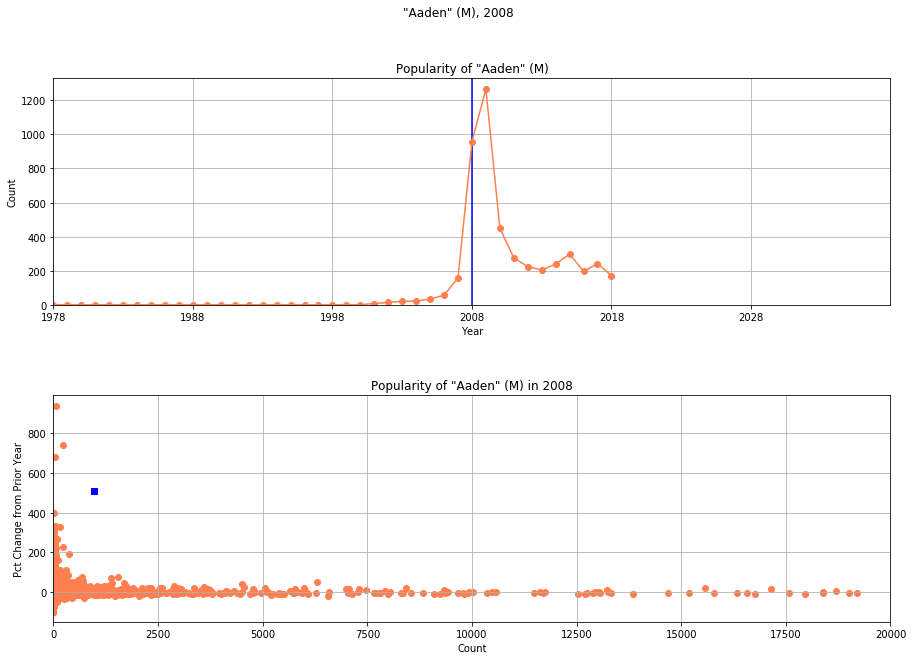

In [6]:
for x in big_spikes_df.iterrows():
    getPlot3(x[1][0],x[1][1],x[1][2])
    break #remove this to make lots of plots
# this takes a long time, a few seconds per plot

This cell was just to research plots for individual names.

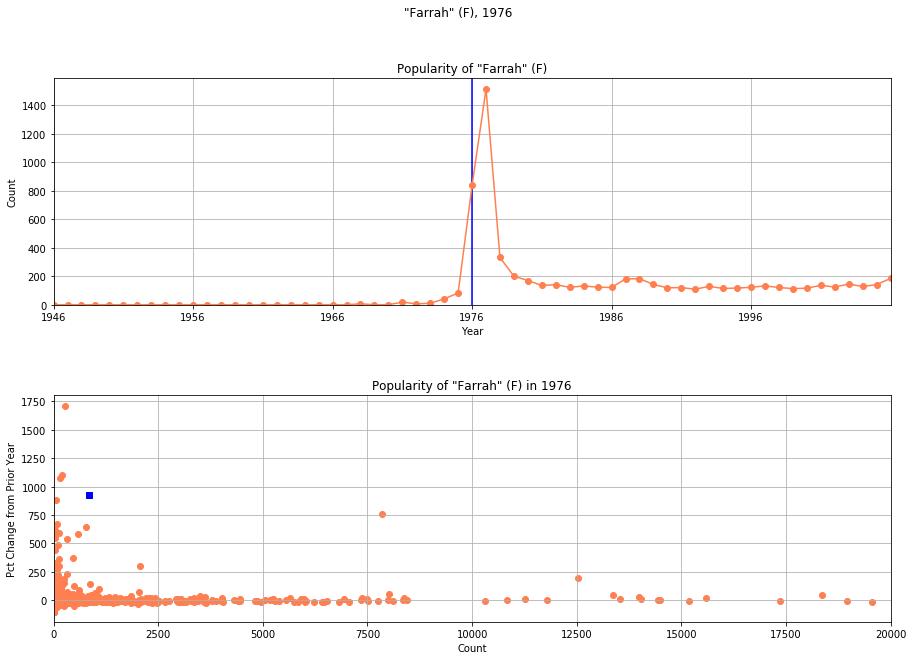

In [7]:
# look at a single name
name = {'name':'Farrah','gender':'F','center':1976}
getPlot3(name['name'],name['gender'],name['center'])

Import movie data and merge with name data. Create a data frame through which to iterate w/the plot function.
Should we clean the data frame up? Remove duplicate columns?

In [8]:
movies_df = pd.read_csv('MovieData/Resources/NameTable.csv')
movies_df['YearAfter'] = movies_df['Year'] + 1

movies_merged_df = pd.merge(movies_df, data_set_with_counts,  how='inner', left_on=['Name','YearAfter'], right_on = ['Name','Year'])

movies_filter_df = movies_merged_df.loc[(movies_merged_df['CountOfNames']>100) 
                          & (movies_merged_df['Percent_Change']>50.00)]

# drop the rows with inf Percent_Change--these shouldn't be big enough spike in terms of count to warrant attention.
# alternative: set them to something arbitrarily high?
movies_filter_df = movies_merged_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

movies_filter_df.rename(columns={'Year_x': 'Year'}, inplace=True)
movies_filter_df.drop(['Year_y'], axis=1,inplace=True)
movies_filter_df.head()
movies_filter_df.sort_values('Percent_Change',ascending = False,inplace=True)

# uncomment to save a csv. adjust path.
#sorted_df.to_csv('movie_spikes.csv')

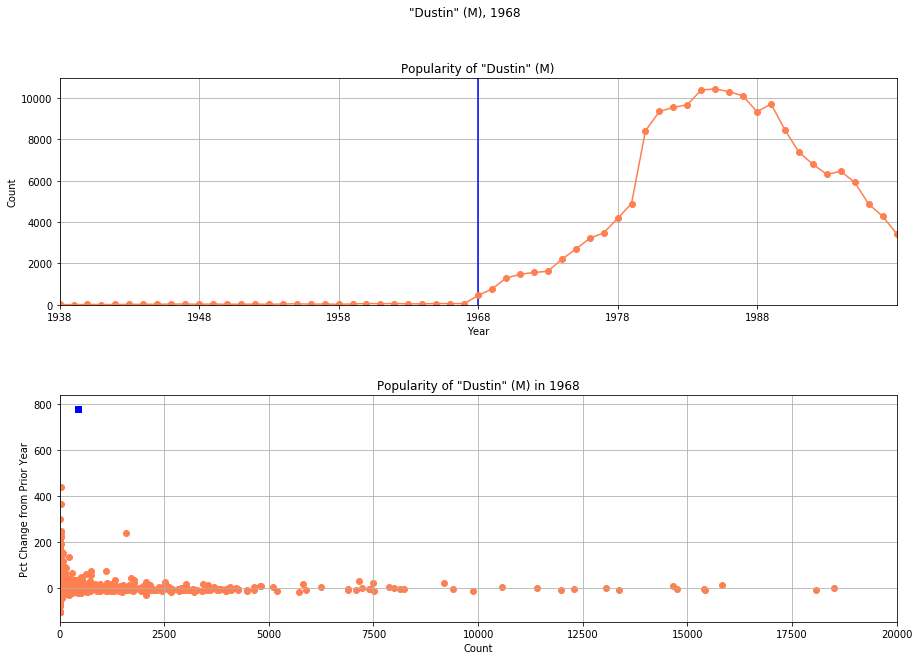

In [9]:
for x in movies_filter_df.iterrows():
    getPlot3(x[1][0],x[1][4],x[1][3])
    break # remove this to iterate through entire dataframe

This section is for the frequency plots, that we elected not to use until we had a chance to clean the data.

In [10]:
# drop the rows with inf Percent_Change--these shouldn't be big enough spike in terms of count to warrant attention.
# alternative: set them to something arbitrarily high?
movies_describe_df = movies_merged_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

movies_describe_df.rename(columns={'Year_x': 'Year'}, inplace=True)
movies_describe_df.drop(['Year_y'], axis=1,inplace=True)
movies_describe_df.head()

,Name,Year,Movie,YearAfter,Gender,CountOfNames,Percent_Change
0,Henry,1915,The Birth of a Nation,1916,F,82.0,13.888889
1,Henry,1915,The Birth of a Nation,1916,M,10656.0,5.109489
2,Lillian,1915,The Birth of a Nation,1916,F,9592.0,0.481877
3,Lillian,1915,The Birth of a Nation,1916,M,26.0,8.333333
4,Mae,1915,The Birth of a Nation,1916,F,2607.0,4.867257


In [11]:
movies_describe_df['Percent_Change'].describe()

count    1195.000000
mean        5.664104
std        51.436886
min      -100.000000
25%        -9.512046
50%        -1.445783
75%        10.062305
max       778.431373
Name: Percent_Change, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1cf003329b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf00332160>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf00332ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf00307160>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf003072b0>],
 'means': []}

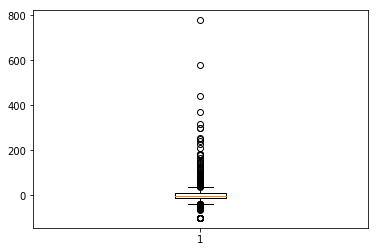

In [12]:
plt.boxplot(movies_describe_df['Percent_Change'])

(array([0.00000000e+00, 5.15021459e-04, 9.44206009e-04, 2.48927039e-03,
        2.06008584e-03, 7.89699571e-03, 2.21459227e-02, 3.03004292e-02,
        1.39914163e-02, 5.06437768e-03, 3.43347639e-03, 2.48927039e-03,
        1.88841202e-03, 1.28755365e-03, 6.00858369e-04, 6.00858369e-04,
        8.58369099e-04, 7.72532189e-04, 2.57510730e-04, 3.43347639e-04,
        8.58369099e-05, 1.71673820e-04, 2.57510730e-04, 8.58369099e-05,
        8.58369099e-05, 2.57510730e-04, 8.58369099e-05, 0.00000000e+00,
        8.58369099e-05, 0.00000000e+00, 8.58369099e-05, 8.58369099e-05,
        1.71673820e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.71673820e-04, 0.00000000e+00, 8.58369099e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.58369099e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.58369099e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

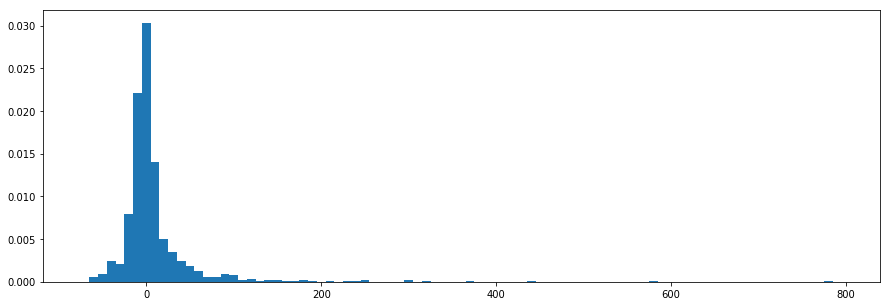

In [13]:
movie_data = movies_describe_df['Percent_Change'].sort_values()
plt.figure(figsize=(15,5))
# plt.hist(data, bins=np.arange(data.min(), data.max(),5))
plt.hist(movie_data, bins=np.arange(-75, 800,10),density=True)

Get plots from the movie data frame.

Import billboard data and merge with name data. Create a data frame through which to iterate w/the plot function. Should we clean the data frame up? Remove duplicate columns?

In [14]:
artists_df = pd.read_csv('summary_df_update.csv')
artists_df['YearAfter'] = artists_df['Date'].str[0:4].astype('int') + 1

songs_merged_df = pd.merge(artists_df, data_set_with_counts,  how='inner', left_on=['First Name','YearAfter'], right_on = ['Name','Year'])

filter_df = songs_merged_df.loc[(songs_merged_df['CountOfNames']>100) 
                          & (songs_merged_df['Percent_Change']>50.00)]
sorted_df = filter_df.sort_values('Percent_Change',ascending = False)

#uncomment to save a csv. adjust path.
# sorted_df.to_csv('Hot100_spikes.csv')

In [38]:
songs_describe_df = songs_merged_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
songs_describe_df.head(10)

,Title,First Name,Date,YearAfter,Name,Gender,Year,CountOfNames,Percent_Change
1,Perfect,Ed,2017-12-30,2018,Ed,M,2018,11.0,57.142857
3,Shape Of You,Ed,2017-04-22,2018,Ed,M,2018,11.0,57.142857
5,Look What You Made Me Do,Taylor,2017-09-23,2018,Taylor,F,2018,2478.0,-8.188218
6,Look What You Made Me Do,Taylor,2017-09-23,2018,Taylor,M,2018,532.0,-7.155323
7,Despacito,Luis,2017-09-02,2018,Luis,F,2018,0.0,-100.000000
8,Despacito,Luis,2017-09-02,2018,Luis,M,2018,3084.0,-8.811354
9,That's What I Like,Bruno,2017-05-06,2018,Bruno,M,2018,378.0,-6.203474
10,Humble.,Kendrick,2017-04-29,2018,Kendrick,F,2018,0.0,-100.000000
11,Humble.,Kendrick,2017-04-29,2018,Kendrick,M,2018,744.0,-4.000000
12,Black Beatles,Rae,2017-01-07,2018,Rae,F,2018,217.0,38.216561


{'whiskers': [<matplotlib.lines.Line2D at 0x1cf003b9128>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf003b97f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf003b0f98>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf003b9e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf003c2208>],
 'means': []}

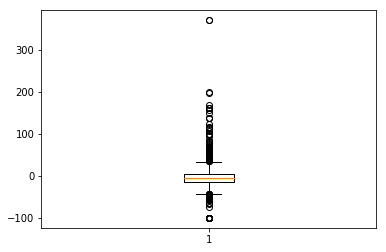

In [16]:
plt.boxplot(songs_describe_df['Percent_Change'])

In [17]:
songs_describe_df['Percent_Change'].describe()

count    1013.000000
mean       -3.049979
std        39.904750
min      -100.000000
25%       -13.800553
50%        -4.565217
75%         5.053563
max       370.716228
Name: Percent_Change, dtype: float64

(array([0.00020683, 0.00062048, 0.00217166, 0.00227508, 0.00465357,
        0.01013444, 0.02616339, 0.02730093, 0.00879007, 0.00517063,
        0.00289555, 0.00299897, 0.00175801, 0.00113754, 0.0008273 ,
        0.00041365, 0.00031024, 0.00020683, 0.00031024, 0.00031024,
        0.        , 0.00031024, 0.00010341, 0.00041365, 0.00010341,
        0.        , 0.        , 0.00020683, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00020683,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

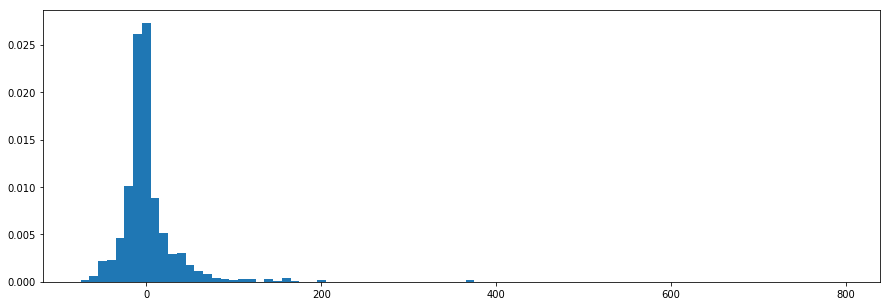

In [18]:
song_data = songs_describe_df['Percent_Change'].sort_values()
plt.figure(figsize=(15,5))
# plt.hist(data, bins=np.arange(data.min(), data.max(),5))
plt.hist(song_data, bins=np.arange(-75,800,10),density=True)

Get plots from the billboard data frame.

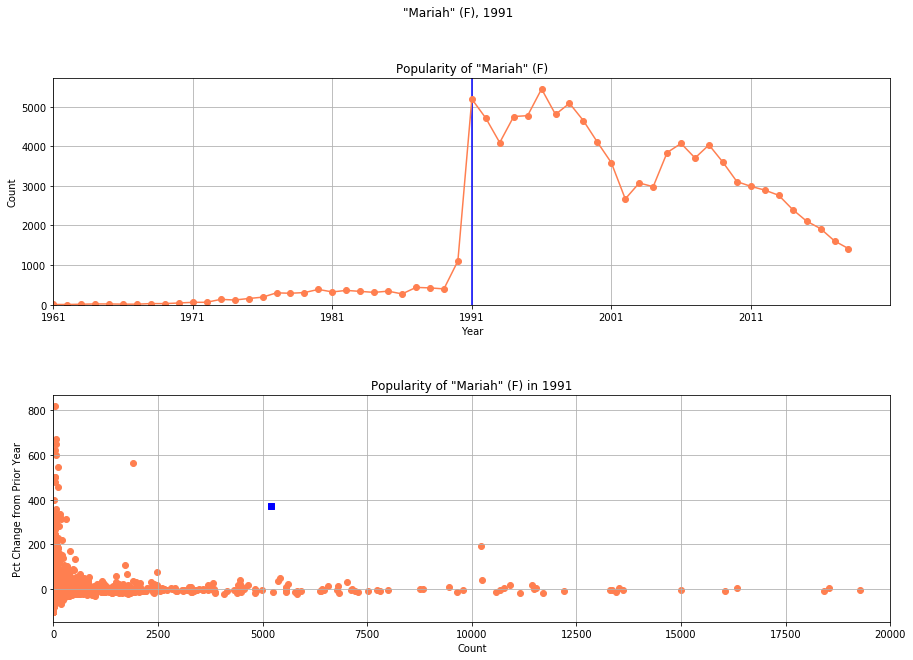

In [19]:
for x in sorted_df.iterrows():
    getPlot3(x[1][4],x[1][5],x[1][6])
    break # remove to iterate through data frame

Get manually researched data from spreadsheet.

In [20]:
df = pd.read_excel('big_spikes.xlsx')
df['Category'].unique()

array(['music', 'tv', 'movie', 'other', 'unknown'], dtype=object)

Get data to plot the grouped bar graph.

In [21]:
music=[]
tv=[]
movie=[]
unknown=[]
other=[]

for dec in np.arange(1890,2020,10):
    music.append(df.loc[(df['Category']=='music') & (df['Decade'] == dec)]['Name'].count())
    tv.append(df.loc[(df['Category']=='tv') & (df['Decade'] == dec)]['Name'].count())
    movie.append(df.loc[(df['Category']=='movie') & (df['Decade'] == dec)]['Name'].count())
    other.append(df.loc[(df['Category']=='other') & (df['Decade'] == dec)]['Name'].count())
    unknown.append(df.loc[(df['Category']=='unknown') & (df['Decade'] == dec)]['Name'].count())

Plot the grouped bar chart. If there were more time, I'd make this better.

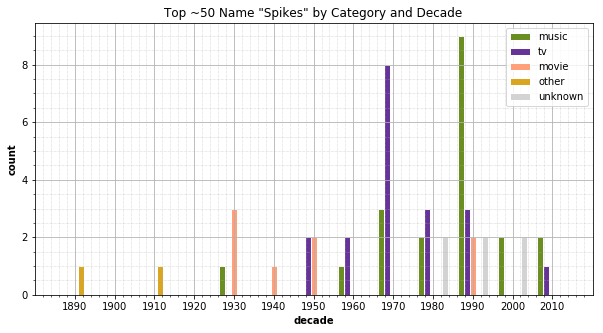

In [22]:
# set width of bar
plt.figure(figsize=[10,5])

barWidth = .15

# Set position of bar on X axis
r1 = np.arange(len(music))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Make the plot
plt.bar(r1, music, facecolor='olivedrab', width=barWidth, edgecolor='white', label='music')
plt.bar(r2, tv, facecolor='rebeccapurple', width=barWidth, edgecolor='white', label='tv')
plt.bar(r3, movie, facecolor='lightsalmon', width=barWidth, edgecolor='white', label='movie')
plt.bar(r4, other, facecolor='goldenrod', width=barWidth, edgecolor='white', label='other')
plt.bar(r5, unknown, facecolor='lightgray', width=barWidth, edgecolor='white', label='unknown')

# Add xticks on the middle of the group bars
plt.xlabel('decade', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.title('Top ~50 Name "Spikes" by Category and Decade')
plt.minorticks_on()
plt.xticks(r3,np.arange(1890,2020,10))

# Create legend & Show graphic
plt.legend()
plt.grid(which = 'minor', linestyle = ':',linewidth = '0.5') # do something with this...
plt.grid(which = 'major', linestyle = '-')
# plt.savefig('top_50_by_category_decade.png', dpi=300)

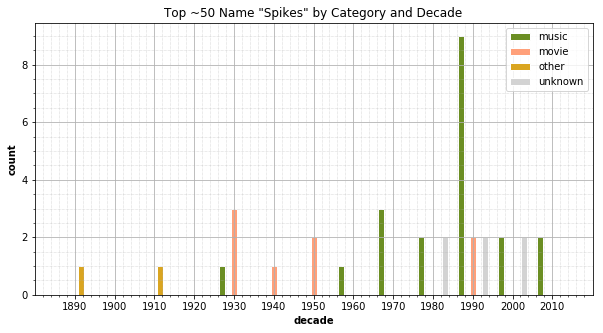

In [23]:
# HIDE TV FOR DRAMATIC EFFECT
# set width of bar
plt.figure(figsize=[10,5])

barWidth = .15

# Set position of bar on X axis
r1 = np.arange(len(music))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Make the plot
plt.bar(r1, music, facecolor='olivedrab', width=barWidth, edgecolor='white', label='music')
plt.bar(r2, 0, facecolor='rebeccapurple', width=barWidth, edgecolor='white')
plt.bar(r3, movie, facecolor='lightsalmon', width=barWidth, edgecolor='white', label='movie')
plt.bar(r4, other, facecolor='goldenrod', width=barWidth, edgecolor='white', label='other')
plt.bar(r5, unknown, facecolor='lightgray', width=barWidth, edgecolor='white', label='unknown')

# Add xticks on the middle of the group bars
plt.xlabel('decade', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.title('Top ~50 Name "Spikes" by Category and Decade')
plt.minorticks_on()
plt.xticks(r3,np.arange(1890,2020,10))

# Create legend & Show graphic
plt.legend()
plt.grid(which = 'minor', linestyle = ':',linewidth = '0.5') # do something with this...
plt.grid(which = 'major', linestyle = '-')
# plt.savefig('No_TV_top_50_by_category_decade.png', dpi=300)

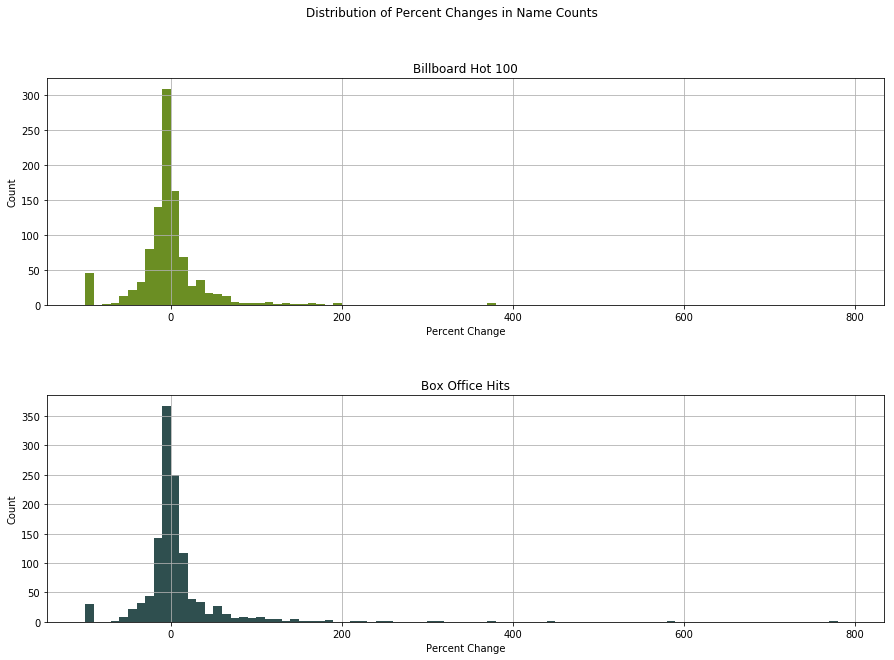

In [24]:
fig, (ax1,ax2) = plt.subplots(nrows = 2,figsize = (15,10),gridspec_kw={'hspace':0.4})
fig.suptitle('Distribution of Percent Changes in Name Counts')

movie_mu = movies_describe_df['Percent_Change'].mean()
movie_sigma = movies_describe_df['Percent_Change'].std()
movie_count = movies_describe_df['Percent_Change'].count()

song_mu = songs_describe_df['Percent_Change'].mean()
song_sigma = songs_describe_df['Percent_Change'].std()
song_count = movies_describe_df['Percent_Change'].count()

# plots
ax1.hist(song_data, bins=np.arange(-100,800,10),facecolor='olivedrab')
ax2.hist(movie_data, bins=np.arange(-100,800,10),facecolor='darkslategray')


# other elements
ax1.set_title('Billboard Hot 100')
ax1.set_ylabel('Count')
ax1.set_xlabel('Percent Change')
ax1.grid()

ax2.set_title('Box Office Hits')
ax2.set_ylabel('Count')
ax2.set_xlabel('Percent Change')
ax2.grid()
plt.savefig('compare_distributions.png', dpi=300)

In [25]:
baby_sum = names_df.groupby(['Gender','Year'])['CountOfNames'].sum()
baby_sum_df = pd.DataFrame(baby_sum)
baby_sum_df.rename(columns={'CountOfNames':'CountOfBabies'},inplace=True)
baby_sum_df.reset_index(inplace=True)
merged_df = pd.merge(data_set_with_counts,baby_sum_df, on=['Gender','Year'])
merged_df['PercentOfNames']=100*merged_df['CountOfNames']/merged_df['CountOfBabies']
merged_df.sort_values(['PercentOfNames'],ascending=False).head()

,Name,Gender,Year,CountOfNames,Percent_Change,CountOfBabies,PercentOfNames
19385,John,M,1880,9655.0,74169.230769,110490,8.738347
60860,John,M,1881,8769.0,-9.176592,100743,8.704327
39627,William,M,1880,9532.0,95220.000000,110490,8.627025
143810,John,M,1883,8894.0,-6.937323,104625,8.500836
81102,William,M,1881,8524.0,-10.574906,100743,8.461134


In [26]:
# merged_df.loc[(merged_df['Year']==2018) & (merged_df['Gender']=='M')].sort_values(['PercentOfNames'],ascending=False)
merged_df.sort_values(['PercentOfNames'],ascending=False).head()

,Name,Gender,Year,CountOfNames,Percent_Change,CountOfBabies,PercentOfNames
19385,John,M,1880,9655.0,74169.230769,110490,8.738347
60860,John,M,1881,8769.0,-9.176592,100743,8.704327
39627,William,M,1880,9532.0,95220.000000,110490,8.627025
143810,John,M,1883,8894.0,-6.937323,104625,8.500836
81102,William,M,1881,8524.0,-10.574906,100743,8.461134


Count of unique names by gender:

In [27]:
names_df.groupby(['Gender'])['Name'].nunique()

Gender
F    67698
M    41475
Name: Name, dtype: int64

Count of names by gender:

In [28]:
names_df.groupby(['Gender'])['CountOfNames'].sum()

Gender
F    174079232
M    177573793
Name: CountOfNames, dtype: int32

Conclusion: There are more unique female names than male names

In [29]:
# create a data frame to pull begin the male/females analysis.

big_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>100) 
                         & (data_set_with_counts["Percent_Change"]>50) 
                         & (data_set_with_counts["Year"]>1889) # to weed out 1880s, which are tainted by 1880 pct changes
                         & (data_set_with_counts["Year"]<2010)] # to weed out 2010s, which are an incomplete decade

# big_spikes_df = data_set_with_counts.loc[(data_set_with_counts["CountOfNames"]>100) 
#                          & (data_set_with_counts["Percent_Change"]>50) 
#                          & (data_set_with_counts["Year"]>1889) 
#                          & (data_set_with_counts["Year"]<2010) 
#                          & (data_set_with_counts["Percent_Change"]!=float('inf'))]

sorted_df = big_spikes_df.sort_values(['Percent_Change'],ascending = False)
sorted_df.count()


Name              6822
Gender            6822
Year              6822
CountOfNames      6822
Percent_Change    6822
dtype: int64

In [30]:
# bin the data by decades
labels = ["{0}s".format(decade) for decade in range(1880, 2020, 10)]
sorted_df['Decade'] = pd.cut(x = sorted_df['Year'], bins=np.arange(1880,2030,10), labels=labels,right = False)

In [31]:
#used this to doublecheck values that looked fishy
#sorted_df.loc[(sorted_df['Decade']=='1890s') & (sorted_df['Gender']=='M')]
#sorted_df.loc[(sorted_df['Decade']=='1890s')]

In [32]:
# make the series to plot
raw_male = sorted_df.groupby(['Gender'])['Decade'].value_counts()['M'].sort_index()
raw_female = sorted_df.groupby(['Gender'])['Decade'].value_counts()['F'].sort_index()

In [33]:
# now bin the names_df to get a count of unique names by decade
names_df['Decade'] = pd.cut(x = names_df['Year'], bins=np.arange(1880,2030,10), labels=labels,right = False)
tot_male = names_df.groupby(['Gender'])['Decade'].value_counts()['M'].sort_index()
tot_female = names_df.groupby(['Gender'])['Decade'].value_counts()['F'].sort_index()

In [34]:
# control for the increased spikes due to more babies and names each decade
normal_df = pd.DataFrame({'TotalUniqueM':tot_male,
                          'TotalUniqueF':tot_female,
                         'SpikeM':raw_male,
                         'SpikeF':raw_female})
normal_df.drop(normal_df.index[0],inplace=True)
normal_df.drop(normal_df.index[-1],inplace=True)
normal_df

,TotalUniqueM,TotalUniqueF,SpikeM,SpikeF
1890s,12191,17331,11.0,25.0
1900s,14383,22292,73.0,53.0
1910s,36913,43600,472.0,206.0
1920s,48591,56771,33.0,65.0
1930s,41713,49777,48.0,160.0
1940s,40403,55239,123.0,351.0
1950s,43857,66667,141.0,365.0
1960s,46366,77810,137.0,336.0
1970s,62226,104971,204.0,550.0
1980s,77896,127928,230.0,711.0


In [35]:
male = 100*normal_df['SpikeM']/normal_df['TotalUniqueM']
female = 100*normal_df['SpikeF']/normal_df['TotalUniqueF']
total_spike = 100*(normal_df['SpikeM']+normal_df['SpikeF'])/(normal_df['TotalUniqueM']+normal_df['TotalUniqueF'])

Text(0.5, 1.0, 'Name Spikes as a Percentage of Unique Names by Gender, Decade')

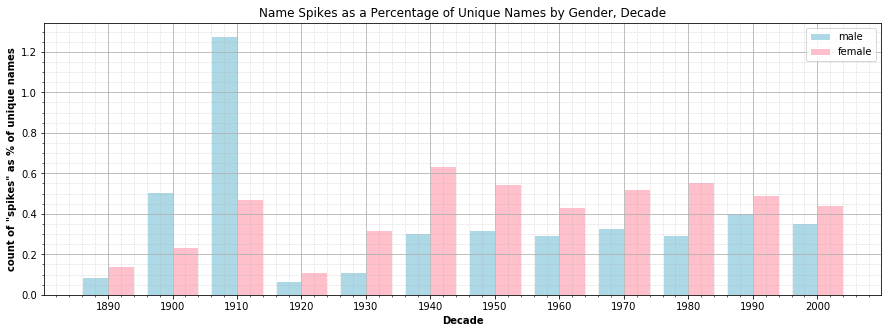

In [36]:
plt.figure(figsize=[15,5])

# set width of bar
barWidth = .4

# Set position of bar on X axis
r1 = np.arange(len(male))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, male, color='lightblue', width=barWidth, edgecolor='white', label='male')
plt.bar(r2, female, color='pink', width=barWidth, edgecolor='white', label='female')

# Add xticks on the middle of the group bars
plt.xlabel('Decade', fontweight='bold')
plt.ylabel('count of "spikes" as % of unique names', fontweight='bold')
plt.minorticks_on()
plt.xticks((r1+r2)/2,np.arange(1890,2010,10))

# Create legend & Show graphic
plt.legend()
plt.grid(which = 'minor', linestyle = ':',linewidth = '0.5') # do something with this...
plt.grid(which = 'major', linestyle = '-')
plt.title('Name Spikes as a Percentage of Unique Names by Gender, Decade')
# plt.savefig('male_v_female.png', dpi=300)

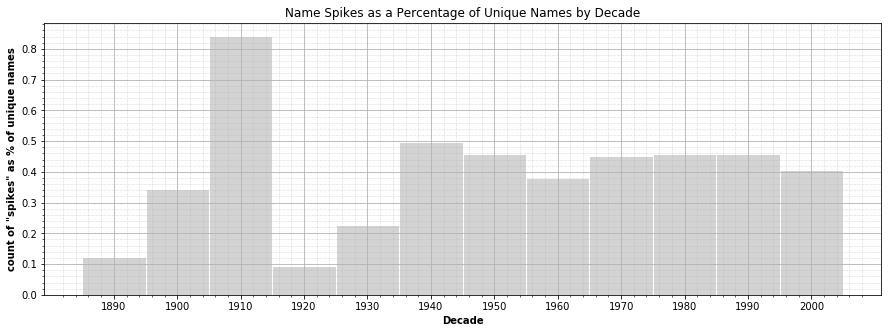

In [37]:
plt.figure(figsize=[15,5])

# set width of bar
barWidth = 1

# Set position of bar on X axis
r1 = np.arange(len(total_spike))

# Make the plot
plt.bar(r1,total_spike, color='lightgray', width=barWidth, edgecolor='white')

# Add xticks on the middle of the group bars
plt.xlabel('Decade', fontweight='bold')
plt.ylabel('count of "spikes" as % of unique names', fontweight='bold')
plt.minorticks_on()
plt.xticks(r1,np.arange(1890,2010,10))

# Create legend & Show graphic
plt.grid(which = 'minor', linestyle = ':',linewidth = '0.5') # do something with this...
plt.grid(which = 'major', linestyle = '-')
plt.title('Name Spikes as a Percentage of Unique Names by Decade')
plt.savefig('name spikes by decade.png', dpi=300)